In [1]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from PartitionedEmbeddingModel import PartitionedEmbeddingModel

CRAFTED_FEATURES = 34

class PartitionedESM2(nn.Module):
    def __init__(self, esm2_model_name, vae_weights_path):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(esm2_model_name)
        self.esm2 = AutoModel.from_pretrained(esm2_model_name)
        for param in self.esm2.parameters():
            param.requires_grad = False

        input_dim = self.esm2.config.hidden_size
        self.ae = PartitionedEmbeddingModel(input_dim, CRAFTED_FEATURES, 1200)
        self.ae.load_state_dict(torch.load(vae_weights_path, map_location="cpu"))
        self.ae.eval()

    def forward(self, sequence):
        tokens = self.tokenizer(sequence, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = self.esm2(**tokens)
            embeddings = outputs.last_hidden_state.squeeze(0)
            mask = tokens["attention_mask"].squeeze(0)
            valid_embeddings = embeddings[mask == 1][1:-1]  # remove CLS and SEP
            _, _, _, z, _ = self.ae(valid_embeddings)
        return z


/Users/Eck00018/Documents/PhD/plmx/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
model = PartitionedESM2(
    esm2_model_name="facebook/esm2_t12_35M_UR50D",
    vae_weights_path="trained_models/lambda_1.5/epoch_1.pt"
)

sequence = "MKTFFLVLAFSLLVFGASQA"
z = model(sequence)
print("Len sequence:", len(sequence))
print("Latent z shape:", z.shape)
print(z)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Len sequence: 20
Latent z shape: torch.Size([20, 480])
tensor([[-0.5054, -0.7107, -0.5743,  ..., -0.0258,  0.2105, -0.2628],
        [-0.3030, -0.2978, -0.5559,  ...,  0.1726,  0.1548, -0.2769],
        [-0.3632, -0.4376, -0.5979,  ...,  0.1522,  0.0866, -0.1846],
        ...,
        [-0.1946, -0.1478, -0.6024,  ...,  0.0390,  0.1357,  0.1198],
        [-0.2782, -0.3582, -0.5910,  ...,  0.1688,  0.0688, -0.1006],
        [ 0.6117, -0.2015, -0.5672,  ...,  0.0154,  0.2969,  0.0197]])


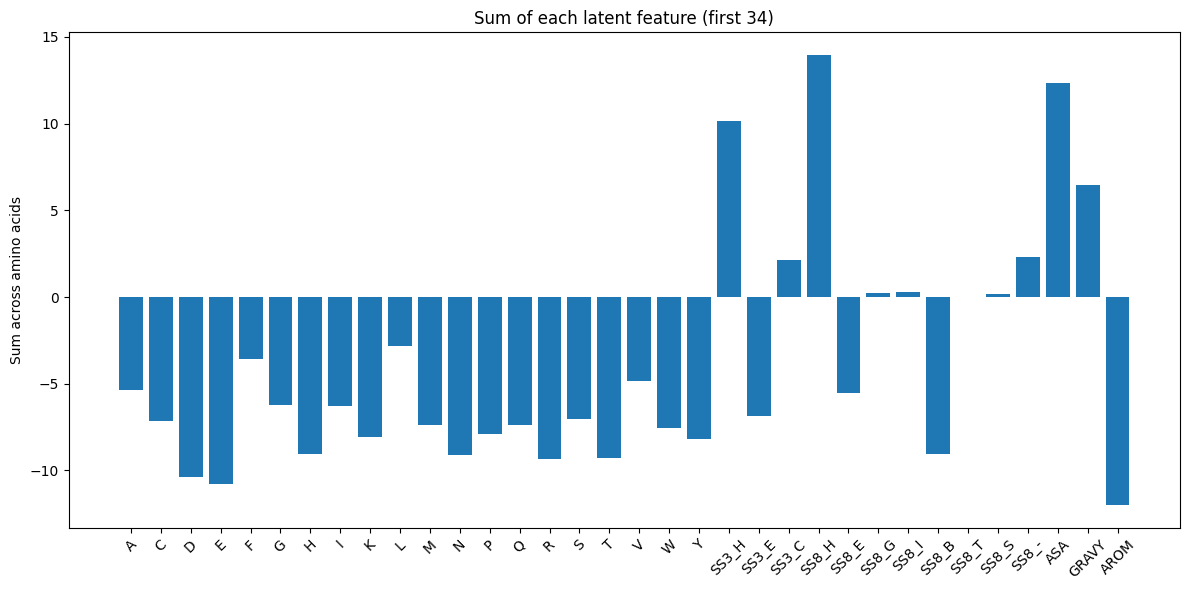

In [16]:
import torch
import matplotlib.pyplot as plt

task_labels = {
    0: 'A', 1: 'C', 2: 'D', 3: 'E', 4: 'F', 5: 'G', 6: 'H', 7: 'I', 8: 'K', 
    9: 'L', 10: 'M', 11: 'N', 12: 'P', 13: 'Q', 14: 'R', 15: 'S', 16: 'T', 
    17: 'V', 18: 'W', 19: 'Y',
    20: 'SS3_H', 21: 'SS3_E', 22: 'SS3_C',
    23: 'SS8_H', 24: 'SS8_E', 25: 'SS8_G', 26: 'SS8_I', 27: 'SS8_B', 
    28: 'SS8_T', 29: 'SS8_S', 30: 'SS8_-',
    31: 'ASA',
    32: 'GRAVY',
    33: 'AROM'
}
z_truncated = z[:, :34]
feature_sums = z_truncated.sum(axis=0)
labels = [task_labels[i] for i in range(34)]

plt.figure(figsize=(12, 6))
plt.bar(labels, feature_sums)
plt.xticks(rotation=45)
plt.ylabel("Sum across amino acids")
plt.title("Sum of each latent feature (first 34)")
plt.tight_layout()
plt.show()
